In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf 
import os 
import numpy as np 

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Input, Flatten, AveragePooling2D, Add
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.datasets import cifar10 
from tensorflow.keras.datasets import fashion_mnist

In [3]:
batch_size=32 
epochs=100
num_classes=10 
depth=20 

In [4]:
model_type = 'MobileNet%d' % (depth)

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() 
x_train = x_train/255 
x_test = x_test/255 

# resize
x_train = np.expand_dims(x_train, axis=-1)
x_train = tf.image.resize(x_train, [32,32]) # if we want to resize 

x_test = np.expand_dims(x_test, axis=-1)
x_test = tf.image.resize(x_test, [32,32]) # if we want to resize 

print(x_train.shape)
print(x_test.shape)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes) 
input_shape=x_train.shape[1:]

4423680/4422102 [==============================] - 0s 0us/step
(60000, 32, 32, 1)
(10000, 32, 32, 1)


In [6]:
#datagen = ImageDataGenerator(rotation_range=10, horizontal_flip=True, zoom_range=0.1, width_shift_range=0.05, height_shift_range=0.05)
#augmented_data = datagen.flow(x_train, y_train)

In [7]:
def mobilenet(input_size=(32, 32), l2_decay=0.1, N_CLASSES=10):
    """
    Builds the MobileNet model.
    :param tuple input_size: The height and width (in that order) of the
        model input.
    :param float l2_decay: The amount of L2 weight decay to add to the
        loss. Applies only to kernels, not biases.
    :return tensorflow.keras.Sequential: A MobileNet model.
    """

    model = Sequential()

    def _add_bn_relu():
        model.add(BatchNormalization(scale=False))
        model.add(ReLU())

    def _add_depthwise_block(strides=1):
        model.add(DepthwiseConv2D(
            (3, 3),
            strides=strides,
            padding='same',
            kernel_regularizer=l2(l=l2_decay)))
        _add_bn_relu()

    def _add_pointwise_block(filters):
        model.add(Conv2D(filters, (1, 1), kernel_regularizer=l2(l=l2_decay)))
        _add_bn_relu()

    model.add(Conv2D(
        32, (3, 3),
        strides=2,
        padding='same',
        kernel_regularizer=l2(l=l2_decay),
        input_shape=input_size + (1,))) # change the channel dimension here
    _add_bn_relu()
    _add_depthwise_block()
    _add_pointwise_block(64)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(128)
    _add_depthwise_block()
    _add_pointwise_block(128)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(256)
    _add_depthwise_block()
    _add_pointwise_block(256)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(512)
    for _ in range(5):
        _add_depthwise_block()
        _add_pointwise_block(512)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(1024)
    _add_depthwise_block()
    _add_pointwise_block(1024)

    model.add(AveragePooling2D(pool_size=(input_size[0] // 32, input_size[1] // 32)))

    model.add(Flatten())
    model.add(Dense(N_CLASSES, kernel_regularizer=l2(l=l2_decay)))
    model.add(Softmax())

    return model


model = mobilenet(input_size=(32, 32), l2_decay=0.001, N_CLASSES=10)
print(model.summary())          

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        96        
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        96        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        2

In [8]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [9]:
#save_dir = os.path.join(os.getcwd(), 'saved_models') 
#model_name = 'cifar10_%s_model_tf.{epoch:03d}.h5'%model_type
#if not os.path.isdir(save_dir):
#    os.makedirs(save_dir)
#filepath = os.path.join(save_dir, model_name)

In [10]:
#checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=2, save_best_only=True)

In [11]:
#callbacks = [checkpoint] 

In [13]:
batch_size = 32 
steps = int(x_train.shape[0]/batch_size) 

history = model.fit(x_train, y_train, steps_per_epoch=steps, epochs=epochs, verbose=2, validation_split=0.1)

Epoch 1/100
1875/1875 - 60s - loss: 3.9519 - accuracy: 0.7476 - val_loss: 3.4530 - val_accuracy: 0.6167
Epoch 2/100
1875/1875 - 26s - loss: 1.6964 - accuracy: 0.8232 - val_loss: 2.0762 - val_accuracy: 0.7045
Epoch 3/100
1875/1875 - 26s - loss: 1.1455 - accuracy: 0.8376 - val_loss: 1.1221 - val_accuracy: 0.8297
Epoch 4/100
1875/1875 - 26s - loss: 0.9851 - accuracy: 0.8476 - val_loss: 0.9360 - val_accuracy: 0.8490
Epoch 5/100
1875/1875 - 27s - loss: 0.8462 - accuracy: 0.8621 - val_loss: 0.8555 - val_accuracy: 0.8478
Epoch 6/100
1875/1875 - 26s - loss: 0.7621 - accuracy: 0.8707 - val_loss: 0.6797 - val_accuracy: 0.8880
Epoch 7/100
1875/1875 - 26s - loss: 0.6816 - accuracy: 0.8812 - val_loss: 0.7028 - val_accuracy: 0.8720
Epoch 8/100
1875/1875 - 26s - loss: 0.6408 - accuracy: 0.8857 - val_loss: 0.6801 - val_accuracy: 0.8527
Epoch 9/100
1875/1875 - 27s - loss: 0.6110 - accuracy: 0.8893 - val_loss: 0.5929 - val_accuracy: 0.8805
Epoch 10/100
1875/1875 - 25s - loss: 0.5664 - accuracy: 0.8953 -

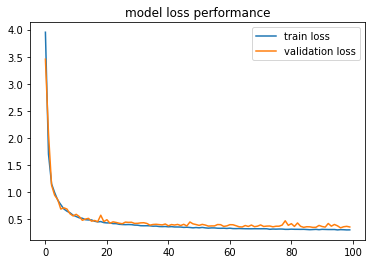

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss performance')
plt.legend(['train loss', 'validation loss'])
plt.show()

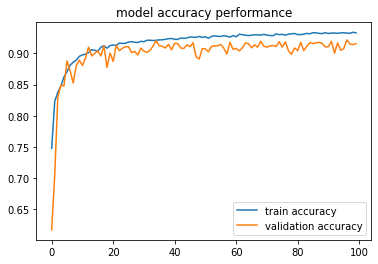

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy performance')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [16]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.3568 - accuracy: 0.9101


[0.3567757308483124, 0.910099983215332]

In [17]:
# https://github.com/mattdutson/mobilenet/blob/master/mobilenet/model.py
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/mobilenet.py
# https://mydeeplearningnb.wordpress.com/2019/07/24/visualizing-cnns-using-tensorflow/